<a href="https://colab.research.google.com/github/abzargar/TextClassification/blob/main/ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [ ]:
import cv2
import glob
import numpy as np
import scipy.io as sio
from scipy.stats import skew
from scipy.stats import kurtosis
import pywt
from skimage.feature import greycomatrix
import progressbar
from time import sleep
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Sub Functions

In [ ]:
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out
  
def hisEqulColor(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img
  
def segment(img):
    ChannelsBGR = cv2.split(img)
    B=ChannelsBGR[0]
    G=ChannelsBGR[1]
    R=ChannelsBGR[2]
#    HSV and YCbCr calculations
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ChannelsHSV = cv2.split(HSV)
    H=ChannelsHSV[0]
    S=ChannelsHSV[1]
    V=ChannelsHSV[2]
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    Channelsycrcb = cv2.split(ycrcb)
    Ydash=Channelsycrcb[0]
    Cb=Channelsycrcb[2]
    Cr=Channelsycrcb[1]
    Ymean=  np.mean(Ydash);
    Crmean= np.mean(Cr);
    Crstd= np.std(Cr);
    #####################Rule 1
    mask1=((Ydash>Cb)&(Ydash>Ymean) &(Cr > Crmean))
    #####################Rule 2 
    mask2=((Ydash>Cr) & (Cb> Cr) &(Cr<(7.4*Crstd)))
    #####################Rule 3
    mask3=((H>=5)&(H<=77)&(S>=51)&(S<=255)&(V>=250)&(V<=255))
    #####################Rule 4
    mask4=((R>G)&(G>B)&(R>np.mean(R)))
    #####################Rules Combination
    maskF=(mask1|mask2|mask3)&mask4;
    ChannelsBGR[2] =(maskF*R);
    ChannelsBGR[1] =(maskF*G);
    ChannelsBGR[0] =(maskF*B);
    cv2.merge(ChannelsBGR, img)
    return img
  
def computeFeatures(region):
    temp_array=region.reshape(-1)
    all_pixels=temp_array[temp_array!=0]   
#     Area
    Area = np.sum(all_pixels)
#     Density (mean)
    density = np.mean(all_pixels)
#    Std_Density
    std_Density = np.std(all_pixels)
#     skewness
    Skewness = skew(all_pixels)
#     kurtosis
    Kurtosis = kurtosis(all_pixels)
#    Energy
    ENERGY =np.sum(np.square(all_pixels))
#    Entropy
    value,counts = np.unique(all_pixels, return_counts=True)
    p = counts / np.sum(counts)
    p =  p[p!=0]
    ENTROPY =-np.sum( p*np.log2(p));
#     Maximum
    MAX = np.max(all_pixels)
#    Mean Absolute Deviation
    sum_deviation= np.sum(np.abs(all_pixels-np.mean(all_pixels)))
    mean_absolute_deviation = sum_deviation/len(all_pixels)
#      Median
    MEDIAN = np.median(all_pixels)
#     Minimum
    MIN = np.min(all_pixels)
#     Range
    RANGE = np.max(all_pixels)-np.min(all_pixels)
#     Root Mean Square
    RMS = np.sqrt(np.mean(np.square(all_pixels)))
#     Uniformity
    UNIFORMITY = np.sum(np.square(p))
#    Center
    NZ=np.nonzero(region)
    x=NZ[0]
    Cx=np.sum(x)/len(x)
    if(len(NZ)==2):
     y=NZ[1]
     Cy=np.sum(y)/len(y)
    else:
     Cy=1.0
    Center=np.sqrt(np.square(Cx)+np.square(Cy))
#    feature vector.....
    features = np.array([Area, density, std_Density,
        Skewness, Kurtosis,ENERGY, ENTROPY,
        MAX, mean_absolute_deviation, MEDIAN, MIN, RANGE, RMS, UNIFORMITY,Center])
    return features
  
def GLDM(inImg, d):
    pro1=np.zeros(inImg.shape,dtype=np.float32)
    pro2=np.zeros(inImg.shape,dtype=np.float32)
    pro3=np.zeros(inImg.shape,dtype=np.float32)
    pro4=np.zeros(inImg.shape,dtype=np.float32)
    for i in range(inImg.shape[0]):
        for j in range(inImg.shape[1]):
            if((j+d)<inImg.shape[1]):
                pro1[i,j]=np.abs(inImg[i,j]-inImg[i,(j+d)])
            if((i-d)>0)&((j+d)<inImg.shape[1]):
                pro2[i,j]=np.abs(inImg[i,j]-inImg[(i-d),(j+d)])
            if((i+d)<inImg.shape[0]):
                pro3[i,j]=np.abs(inImg[i,j]-inImg[(i+d),j])
            if((i-d)>0)&((j-d)>0):
                pro4[i,j]=np.abs(inImg[i,j]-inImg[(i-d),(j-d)])
    n=256;
    cnt, bin_edges=np.histogram(pro1[pro1!=0], bins=np.arange(n)/(n-1), density=False)
    Out1 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro2[pro2!=0], bins=np.arange(n)/(n-1), density=False)
    Out2 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro3[pro3!=0], bins=np.arange(n)/(n-1), density=False)
    Out3 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro4[pro4!=0], bins=np.arange(n)/(n-1), density=False)
    Out4 = cnt.cumsum()
    return Out1,Out2,Out3,Out4
  
def FeatureExtraction(region):
    gray=im2double(cv2.cvtColor(region, cv2.COLOR_BGR2GRAY))
    F1=computeFeatures(gray)
    Ft=np.fft.fft2(gray)
    Ft = np.fft.fftshift(Ft)
    Ft = np.abs(Ft)
    YC=int(np.floor(Ft.shape[1]/2)+1)
    Ft=Ft[:,YC:int(np.floor(3*YC/2))]
    F2=computeFeatures(Ft)
    coeffs = pywt.dwt2(gray,'sym4')
    cA1, (cH1, cV1, cD1) = coeffs
    coeffs = pywt.dwt2(cA1,'sym4')
    cA2, (cH2, cV2, cD2) = coeffs
    F3=np.concatenate((computeFeatures(cA1), computeFeatures(cH1),computeFeatures(cV1),computeFeatures(cD1)
    ,computeFeatures(cA2), computeFeatures(cH2),computeFeatures(cV2),computeFeatures(cD2)), axis=0)
    gLDM1,gLDM2,gLDM3,gLDM4=GLDM(gray,10)
    F4=np.concatenate((computeFeatures(gLDM1), computeFeatures(gLDM2),computeFeatures(gLDM3),computeFeatures(gLDM4)), axis=0)
    glcms =greycomatrix(cv2.cvtColor(region, cv2.COLOR_BGR2GRAY), [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    F5=np.concatenate((computeFeatures(im2double(glcms[:, :, 0, 0])), computeFeatures(im2double(glcms[:, :, 0, 1])),computeFeatures(im2double(im2double(glcms[:, :, 0, 2]))),computeFeatures(glcms[:, :, 0, 3])), axis=0)
    return np.concatenate((F1,F2,F3,F4,F5), axis=0).reshape(1,270)
  
def ReadVideosandExtarctFeatures(dirNamein):
  files = [f for f in glob.glob(dirNamein + "**/*.avi", recursive=True)]
  bar = progressbar.ProgressBar(maxval=len(files),widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  FinalFeatures=np.empty([1,270])
  ip=1
  bar.update(ip, force=True)
  bar.start()
  for f in files:
      cap=cv2.VideoCapture(f)
      FC=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      Features=np.empty([1,270])
      bar.update(ip, force=True)
      #print(ip)
      ip+=1

      for n in range(FC):
          ret, img = cap.read()
          if ret==True:
              img = hisEqulColor(img)
              img = cv2.medianBlur(img,3)
              region=segment(img)
              if np.sum(region)!=0:
                  Features=np.concatenate((Features,FeatureExtraction(region)), axis=0)           
      Features=np.delete(Features, 0, 0)
      FinalFeatures=np.concatenate((FinalFeatures,np.sum(np.abs(np.diff(Features,axis=0)),axis=0).reshape(1,270)),axis=0)
  bar.finish()
  FinalFeatures=np.delete(FinalFeatures, 0, 0)
  return FinalFeatures


def build_basic_model(feature_size, n_classes):
    inp = kl.Input((feature_size,))
    x=kl.Dropout(0.5)(inp)
    x = kl.Dense(500, activation='sigmoid')(inp)
    x=kl.Dropout(0.5)(x)
    x = kl.Dense(32, activation='sigmoid')(x)
    x=kl.Dropout(0.5)(x)
    out = kl.Dense(n_classes, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.summary()
    return model

def show_model(model):
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='temp_model.png')
    return Image(filename='temp_model.png')


  

# Feature Extraction
This step takes a long time to finish (around three hours on my system)

In [ ]:
dirNamein='/content/drive/My Drive/Output/FireVideos'
print('Please wait....')
FireFeatures=ReadVideosandExtarctFeatures(dirNamein)
sio.savemat('/content/drive/My Drive/FireFeatures.mat', {'FireFeatures': FireFeatures})
print('Fire feature matrix size:')
print(FireFeatures.shape)



[========================================================================] 100%


Fire feature matrix size:
(246, 270)


In [ ]:

dirNamein='/content/drive/My Drive/Output/LikefireVideos'
print('Please wait....')
LikeFireFeatures=ReadVideosandExtarctFeatures(dirNamein)
sio.savemat('/content/drive/My Drive/LikeFireFeatures.mat', {'LikeFireFeatures': LikeFireFeatures})
print('Non-Fire feature matrix size:')
print(LikeFireFeatures.shape)

[========================================================================] 100%


Non-Fire feature matrix size:
(256, 270)


# ّFeature Reduction/Selection

In [ ]:

#f=sio.loadmat('/content/drive/My Drive/FireFeatures.mat')
#FinalFeatures=f['FireFeatures']
FinalFeatures=FireFeatures
n1=FinalFeatures.shape[0]
Features=FinalFeatures
#f=sio.loadmat('/content/drive/My Drive/LikefireFeatures.mat')
#FinalFeatures=f['LikeFireFeatures']
FinalFeatures=LikeFireFeatures
Features=np.concatenate((Features,FinalFeatures), axis=0)
print('Old feature pool size:')
print(Features.shape)
min_max_scaler = preprocessing.MinMaxScaler()
Features = min_max_scaler.fit_transform(Features)
transformer = KernelPCA(n_components=100, kernel='linear')
X = transformer.fit_transform(Features)
y=np.zeros([X.shape[0],1])
y[0:n1]=1
y = to_categorical(y)
print('New feature pool size:')
X.shape



Old feature pool size:
(502, 270)
New feature pool size:


(502, 100)

# Multi layer neural network and classification

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               50500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16032     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)      

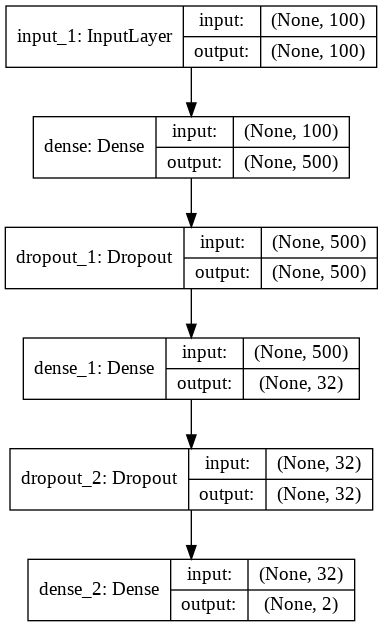

In [ ]:

kl = keras.layers
model = build_basic_model(feature_size=X.shape[-1], n_classes=y.shape[-1])
show_model(model)

# Train the created model

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

opt = tf.keras.optimizers.Adam(lr=0.001)
criterion = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=criterion)
model.fit(X_train, y_train,batch_size = 16,epochs=250, validation_data = (X_val, y_val))
Y_Score=model.predict(X_test)
y_pred = np.argmax(Y_Score, axis=1)

Train on 300 samples, validate on 101 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
300/300 [==============================] - 3s 11ms/sample - loss: 0.7535 - val_loss: 0.6919
Epoch 2/250
300/300 [==============================] - 0s 353us/sample - loss: 0.6986 - val_loss: 0.6891
Epoch 3/250
300/300 [==============================] - 0s 336us/sample - loss: 0.6842 - val_loss: 0.6878
Epoch 4/250
300/300 [==============================] - 0s 333us/sample - loss: 0.6952 - val_loss: 0.6858
Epoch 5/250
300/300 [==============================] - 0s 333us/sample - loss: 0.6937 - val_loss: 0.6848
Epoch 6/250
300/300 [==============================] - 0s 342us/sample - loss: 0.6900 - val_loss: 0.6818
Epoch 7/250
300/300 [==============================] - 0s 316us/sample - loss: 0.6934 - val_loss: 0.6791
Epoch 8/250
300/300 [==============================] - 0s 435us/sample - loss: 0.6739 - val_loss: 0.6736
Epoch 9/250
300/300 [==============================] - 0s 366us/sam

# Evaluate the trained model

[[51  7]
 [ 2 41]]
              precision    recall  f1-score   support

        Fire       0.96      0.88      0.92        58
    LikeFire       0.85      0.95      0.90        43

    accuracy                           0.91       101
   macro avg       0.91      0.92      0.91       101
weighted avg       0.92      0.91      0.91       101



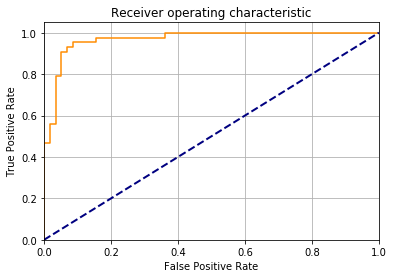

0.9687249398556536


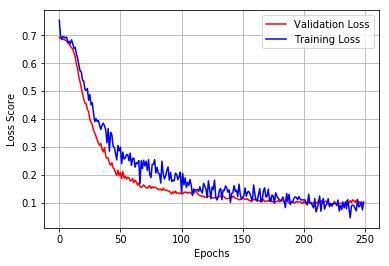

In [ ]:

print(confusion_matrix(np.argmax(y_test, axis=1),y_pred))
target_names = ['Fire', 'LikeFire']
print(classification_report(np.argmax(y_test, axis=1),y_pred, target_names=target_names))
fpr, tpr, thresholds = metrics.roc_curve(y_test[:,1], Y_Score[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.grid(1)
plt.show()
print(roc_auc_score(y_test[:,1], Y_Score[:,1]))
plt.plot(model.history.history['val_loss'], 'r', model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss Score')
plt.legend(['Validation Loss','Training Loss'])
plt.grid(1)
plt.show()